# Analysis of the cold plasma dispersion relation

# 1. Without linear growth

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import Utilitis_HybridCode as utils
from scipy import signal
from matplotlib.colors import LogNorm
from matplotlib.patches import ConnectionPatch
# ...

In [2]:
# ... import simulation data
data = np.loadtxt('/home/florian/Schreibtisch/Masterarbeit/06_Github/mhd/02_HybridModelling/Results/01_NoDipoleField/02_ZeroIC/simulation_data_T=300_L=80.txt')
# ...

In [3]:
# ... get simulation parameters
pa = data[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
xi    = pa[24]
Ld    = pa[25]

bcs_p = pa[26]
bcs_f = pa[27]
bcs_d = pa[28]
bcs_g = pa[29]

bcs_f = 1 # account for periodic boundary conditions
# ...

In [4]:
T

300.0

In [5]:
# ... additional parameters (number of FEM coefficients Nb and number of unknowns s) 
if bcs_f == 1:
    Nb = Nz
elif bcs_f == 2:
    Nb = Nz + p - 2
s = 6
# ...



# ... discretization parameters (space and time grid)
dz = Lz/Nz
zj = np.linspace(0, Lz, Nz + 1)

Nt = np.int(T/dt)
tn = np.linspace(0, T, Nt + 1)
# ...




# ... get simulation data
if bcs_f == 1:

    uj = data[1:, 0:s*Nb]
    yhj = data[1:, s*Nb:8*Nb]
    
    Nt_data = len(uj[:, 0]) - 1
    dt_data = dt
    tn_data = np.linspace(0, Nt_data*dt_data, Nt_data + 1)

    ejx = uj[:, 0::6]
    ejy = uj[:, 1::6]
    bjx = uj[:, 2::6]
    bjy = uj[:, 3::6]
    
    ycjx = uj[:, 4::6]
    ycjy = uj[:, 5::6]
    
    yhjx = yhj[:, 0::2]
    yhjy = yhj[:, 1::2]

elif bcs_f == 2:

    uj = data1[1:, 0:s*Nb]
    yhj = data1[1:, s*Nb:8*Nb]
    
    Nt_data = len(uj[:, 0]) - 1
    dt_data = dt
    tn_data = np.linspace(0, Nt_data*dt_data, Nt_data + 1)

    ejx = np.c_[np.zeros(Nt_data + 1), uj[:, 0::6], np.zeros(Nt_data + 1)]
    ejy = np.c_[np.zeros(Nt_data + 1), uj[:, 1::6], np.zeros(Nt_data + 1)]
    bjx = np.c_[np.zeros(Nt_data + 1), uj[:, 2::6], np.zeros(Nt_data + 1)]
    bjy = np.c_[np.zeros(Nt_data + 1), uj[:, 3::6], np.zeros(Nt_data + 1)]
    
    ycjx = np.c_[np.zeros(Nt_data + 1), uj[:, 4::6], np.zeros(Nt_data + 1)]
    ycjy = np.c_[np.zeros(Nt_data + 1), uj[:, 5::6], np.zeros(Nt_data + 1)]
    yhjx = yhj[:, 0::2]
    yhjy = yhj[:, 1::2]
# ...


# ... define masking function and background magnetic field
def damp(z):
    return 0*z

def B0(z):
    return 0*z
# ...



# ... create B-spline basis and compute mass matrix
basis, N, quad_points, weights = utils.createBasis(Lz, Nz, p, bcs_f)
M = utils.matrixAssembly(basis, weights, quad_points, B0, bcs_f)[0]
# ...



# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = utils.solveDispersionHybrid(k, +1, c, wce, wpe, wpar, wperp, nuh, 0.5 + 0j, 1e-6, 100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...

In [6]:
gamma

-5.4432855797287064e-05

Text(0.5,1,'spectrogram in linear phase')

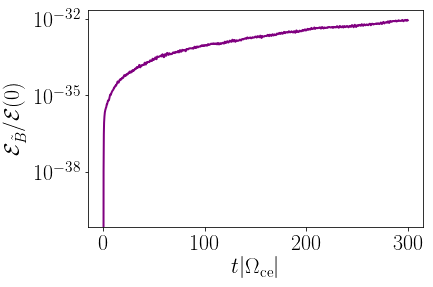

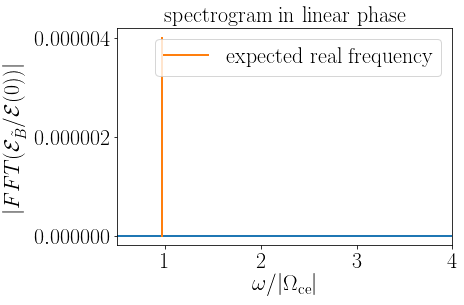

In [7]:
fontsize = 22
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)



# ... compute magnetic field energy and normalize to total initial energy
Eh_eq = Lz*nh*me/2*(wpar**2 + 2*wperp**2)
en_B = np.zeros(Nt_data + 1)

for j in range(0, Nt_data + 1):
    en_B[j] = 1/(2*mu0)*(np.dot(bjx[j], np.dot(M, bjx[j])) + np.dot(bjy[j], np.dot(M, bjy[j]))) 
    
en_B_norm = en_B/(Eh_eq + en_B[0])
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntend = Nt_data
spec = np.fft.fft(en_B_norm[0:Ntend + 1])
spec = np.fft.fftshift(spec)
w = np.linspace(0, Ntend, Ntend + 1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt_data)
# ...


                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(4)
f1.set_figwidth(6)


plt.semilogy(tn_data, en_B_norm, label = 'numerics', color = 'purple', linewidth = 2)
plt.xlabel('$t|\Omega_\mathrm{ce}|$')
plt.ylabel(r'$\mathcal{E}_{\tilde{B}} / \mathcal{E}(0)$')



f2 = plt.figure()
f2.set_figheight(4)
f2.set_figwidth(6)

plt.plot(w, np.abs(spec), linewidth = 2)
plt.xlim((0.5, 4))
plt.xlabel(r'$\omega/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$|FFT(\mathcal{E}_{\tilde{B}} / \mathcal{E}(0))|$')
plt.plot(np.ones(20)*2*omega_r, np.linspace(0, 4e-6, 20), label = 'expected real frequency', linewidth = 2)
plt.legend()
plt.title('spectrogram in linear phase', fontsize = fontsize)
# ...

In [8]:
# ... compute Bx on a space-time-grid and create w- and k- vectors
w = np.linspace(0, Nt_data, Nt_data + 1) - Nt_data/2
w = 2*np.pi/T*w

ks = np.linspace(0, Nz, Nz + 1) - Nz/2
ks = 2*np.pi/Lz*ks

Bx = np.zeros((Nt_data + 1, Nz + 1))

for i in range(0, Nt_data + 1):
    if i%1000 == 0:
        print(i)
    Bx[i] = utils.evaluation(bjx[i], basis, zj, zj, bcs_f)
# ...

0
1000
2000
3000
4000
5000
6000


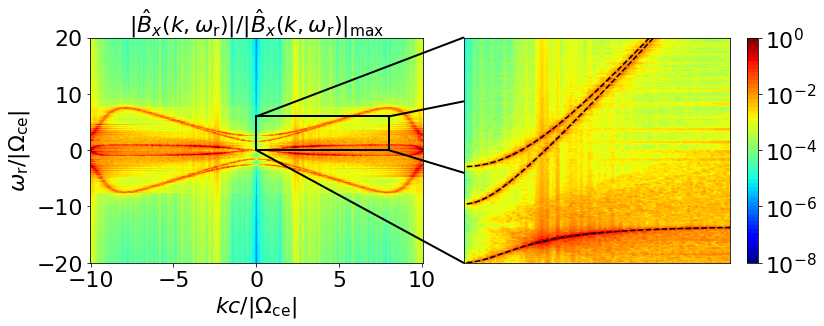

In [19]:
fontsize = 22
plt.rc('text', usetex = False)
plt.rc('font', family = 'sans-serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)


# ... compute 2D fft and plot result
Bxkw = np.fft.fft2(Bx)
K, W = np.meshgrid(ks, w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)


f2 = plt.figure()
f2.set_figheight(5)
f2.set_figwidth(12)

ax1 = plt.subplot(121)


ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.plot(np.linspace(0, 8, 10), np.zeros(10), 'k', linewidth = 2)
plt.plot(np.linspace(0, 8, 10), np.ones(10)*6, 'k', linewidth = 2)
plt.plot(np.zeros(10), np.linspace(0, 6, 10), 'k', linewidth = 2)
plt.plot(np.ones(10)*8, np.linspace(0, 6, 10), 'k', linewidth = 2)
#plt.xlim((0, 6))
plt.ylim((-20, 20))
plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
#plt.colorbar(ticks = ticks)
plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$', fontsize = fontsize)
#plt.savefig('/home/florian/Schreibtisch/Masterarbeit/05_Präsentationen/03_Ringberg/result1.png', bbox_inches = 'tight')

ax2 = plt.subplot(122)

# ... analytic dispersion relation
k1 = np.linspace(0.1, 8.0, 40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0, 40):
    
    if i == 0:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i], 1e-6, 100)[0]
    
    else:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i-1], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i-1], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i-1], 1e-6, 100)[0]
    

    

ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.xlim((0, 8))
plt.ylim((0, 6))
#plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
#plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
plt.colorbar(ticks = ticks)
#plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$')
plt.xticks([], [])
plt.yticks([], [])
plt.plot(k1, w1_1, 'k--')
plt.plot(k1, w1_2, 'k--')
plt.plot(k1, w1_3, 'k--')
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()




con1 = ConnectionPatch(xyA = (0, 6), xyB = (0, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)
con2 = ConnectionPatch(xyA = (0, 0), xyB = (0, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)
con3 = ConnectionPatch(xyA = (0, 4.3), xyB = (8, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)
con4 = ConnectionPatch(xyA = (0, 2.4), xyB = (8, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)

ax2.add_artist(con1)
ax2.add_artist(con2)
ax2.add_artist(con3)
ax2.add_artist(con4)

plt.savefig('/home/florian/Schreibtisch/Masterarbeit/05_Präsentationen/05_Colloquium/01_Figures/Spectrum_kw.png', bbox_inches = 'tight')
# ...

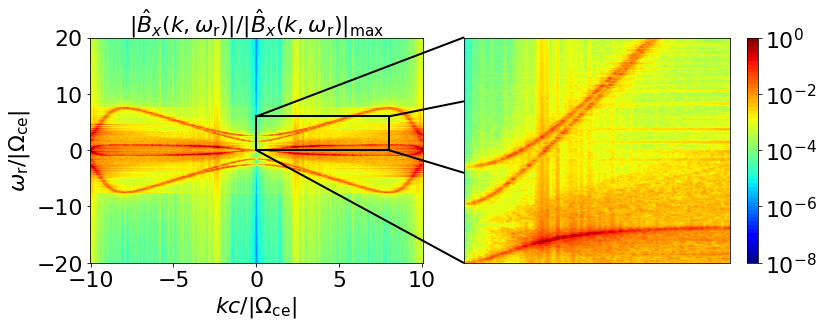

In [20]:
fontsize = 22
plt.rc('text', usetex = False)
plt.rc('font', family = 'sans-serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)


# ... compute 2D fft and plot result
Bxkw = np.fft.fft2(Bx)
K, W = np.meshgrid(ks, w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)


f2 = plt.figure()
f2.set_figheight(5)
f2.set_figwidth(12)

ax1 = plt.subplot(121)


ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.plot(np.linspace(0, 8, 10), np.zeros(10), 'k', linewidth = 2)
plt.plot(np.linspace(0, 8, 10), np.ones(10)*6, 'k', linewidth = 2)
plt.plot(np.zeros(10), np.linspace(0, 6, 10), 'k', linewidth = 2)
plt.plot(np.ones(10)*8, np.linspace(0, 6, 10), 'k', linewidth = 2)
#plt.xlim((0, 6))
plt.ylim((-20, 20))
plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
#plt.colorbar(ticks = ticks)
plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$', fontsize = fontsize)
#plt.savefig('/home/florian/Schreibtisch/Masterarbeit/05_Präsentationen/03_Ringberg/result1.png', bbox_inches = 'tight')

ax2 = plt.subplot(122)

# ... analytic dispersion relation
k1 = np.linspace(0.1, 8.0, 40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0, 40):
    
    if i == 0:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i], 1e-6, 100)[0]
    
    else:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i-1], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i-1], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i-1], 1e-6, 100)[0]
    

    

ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.xlim((0, 8))
plt.ylim((0, 6))
#plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
#plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
plt.colorbar(ticks = ticks)
#plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$')
plt.xticks([], [])
plt.yticks([], [])
#plt.plot(k1, w1_1, 'k--')
#plt.plot(k1, w1_2, 'k--')
#plt.plot(k1, w1_3, 'k--')
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()




con1 = ConnectionPatch(xyA = (0, 6), xyB = (0, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)
con2 = ConnectionPatch(xyA = (0, 0), xyB = (0, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)
con3 = ConnectionPatch(xyA = (0, 4.3), xyB = (8, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)
con4 = ConnectionPatch(xyA = (0, 2.4), xyB = (8, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 2)

ax2.add_artist(con1)
ax2.add_artist(con2)
ax2.add_artist(con3)
ax2.add_artist(con4)

plt.savefig('/home/florian/Schreibtisch/Masterarbeit/05_Präsentationen/05_Colloquium/01_Figures/Spectrum_kw_0.png', bbox_inches = 'tight')
# ...

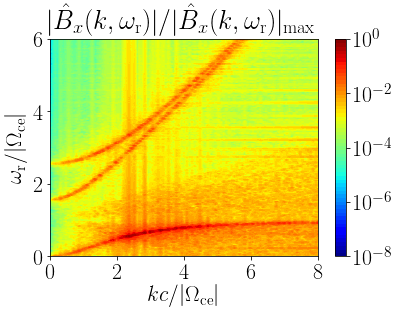

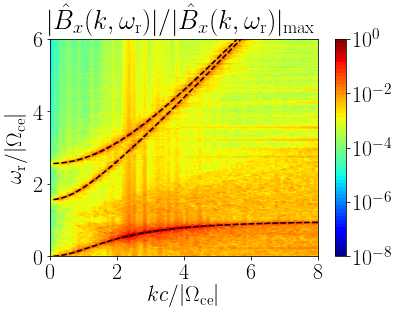

In [13]:
fontsize = 22
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)


# ... compute 2D fft and plot result
Bxkw = np.fft.fft2(Bx)
K, W = np.meshgrid(ks, w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)


f3 = plt.figure()
f3.set_figheight(4)
f3.set_figwidth(6)


ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.xlim((0, 8))
plt.ylim((0, 6))
plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
plt.colorbar(ticks = ticks)
plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$')
#plt.savefig('/home/florian/Schreibtisch/Masterarbeit/05_Präsentationen/05_Colloquium/01_Figures/test.pdf', bbox_inches = 'tight')
# ...



# ... analytic dispersion relation
k1 = np.linspace(0.1, 8.0, 40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0, 40):
    
    if i == 0:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i], 1e-6, 100)[0]
    
    else:
        w1_1[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i-1], 1e-6, 100)[0]
        w1_2[i] = utils.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i-1], 1e-6, 100)[0]
        w1_3[i] = utils.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i-1], 1e-6, 100)[0]
    

    
    
f4 = plt.figure()
f4.set_figheight(4)
f4.set_figwidth(6)

ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.xlim((0, 8))
plt.ylim((0, 6))
plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
plt.colorbar(ticks = ticks)
plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$')
plt.plot(k1, w1_1, 'k--')
plt.plot(k1, w1_2, 'k--')
plt.plot(k1, w1_3, 'k--')
#plt.savefig('/home/florian/Schreibtisch/Masterarbeit/05_Präsentationen/03_Ringberg/result2.png', bbox_inches = 'tight')
# ...